<a href="https://colab.research.google.com/github/ALejandroCh17/Tennis-Ball-Robot/blob/daniel_branch/rally_rover_tennis_ball_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tennis Ball Image Binary Classification

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing modules

In [106]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import os
import random
from hashlib import sha256
from PIL import Image
from tensorflow.keras.optimizers import RMSprop

## Exploratory Data Analysis

In [107]:
# Define the paths to the folders containing the images
folders = [
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls',
    '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'
]

**Sample Image Display**

In [108]:
# Gather all image paths from the folders
all_image_paths = []
for folder in folders:
    for image_name in os.listdir(folder):
        all_image_paths.append(os.path.join(folder, image_name))

In [109]:
# Select 5 random images from the entire dataset
selected_image_paths = random.sample(all_image_paths, 5)

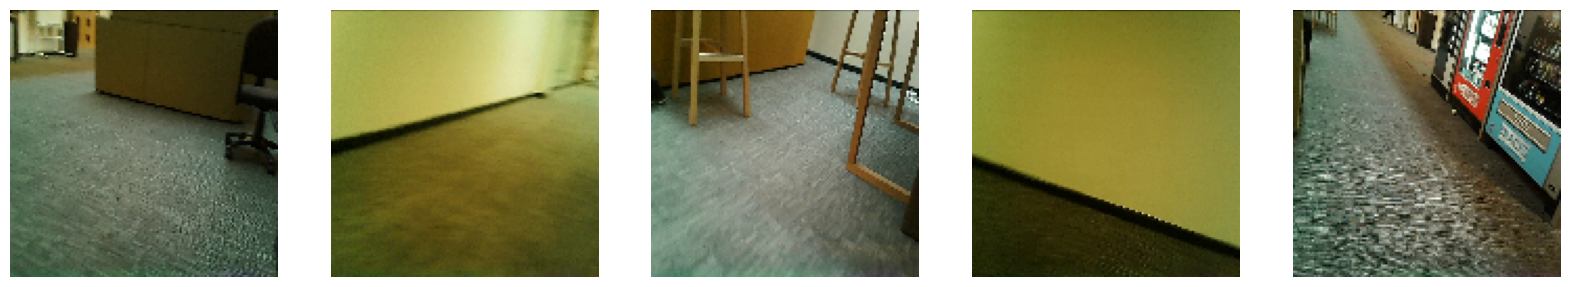

In [110]:
# Plot the selected images
plt.figure(figsize=(20, 4))
for i, img_path in enumerate(selected_image_paths):
    img = load_img(img_path, color_mode='rgb', target_size=(128, 128))  # Load and resize the image
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

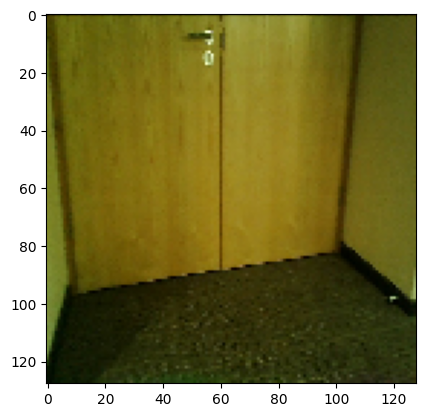

In [111]:
# Showing no ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty/empty517.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

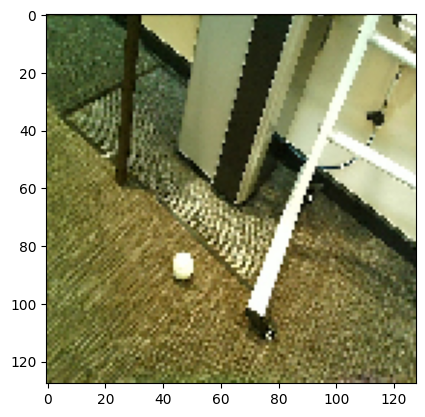

In [112]:
# Showing ball image
img = load_img('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls/ball97.jpg', color_mode='rgb', target_size=(128,128))
img_arr = img_to_array(img)
plt.imshow(img)

A comparison between both image confirms our expectation of a ball either present or not present.

In [113]:
# Converts images to arrays for processing.
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = load_img(os.path.join(folder,filename), color_mode='rgb', target_size=(128, 128))
        img_arr = img_to_array(img)
        images.append(img_arr)
    return images

**Label Distribution**

In [114]:
x_train_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls')
x_train_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty')
x_test_balls = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls')
x_test_empty = load_images_from_folder('/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty')

In [115]:
# Set the directory for each class
dir_train_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/balls'
dir_train_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/train/empty'
dir_test_balls = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/balls'
dir_test_empty = '/content/drive/My Drive/Capstone Dataset/Binary Tennis Ball Classification/test/empty'

In [116]:
# Count the number of images in each directory
total_balls = len(os.listdir(dir_train_balls)) + len(os.listdir(dir_test_balls))
total_empty = len(os.listdir(dir_train_empty)) + len(os.listdir(dir_test_empty))

print(f'Balls: {total_balls}')
print(f'Empty: {total_empty}')

Balls: 446
Empty: 446


There are equal number of both types of images after modifying google drive file.

In [117]:
def check_image_sizes(directories):
    unique_sizes = set()

    for directory in directories:
        for filename in os.listdir(directory):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                image_path = os.path.join(directory, filename)
                with Image.open(image_path) as img:
                    unique_sizes.add(img.size)  # img.size is a tuple (width, height)

    # If there's only one unique size in the set, all images are the same size
    return len(unique_sizes) == 1, unique_sizes

In [118]:
# Use the function and print the result
all_same_size, unique_sizes = check_image_sizes(folders)
print(f"All images across all folders are the same size: {all_same_size}")
if not all_same_size:
    print(f"Unique image sizes found across all folders: {unique_sizes}")

All images across all folders are the same size: True


## Data Preprocessing

**Removing Duplicates**

In [119]:
# Concatenating no-ball and yes-ball sets together
y_train = np.concatenate( ( np.ones(len(x_train_balls)), np.zeros(len(x_train_empty))) )
x_train = np.concatenate( (np.array(x_train_balls), np.array(x_train_empty) ) )
y_test = np.concatenate( (np.ones(len(x_test_balls)), np.zeros(len(x_test_empty))) )
x_test = np.concatenate( (np.array(x_test_balls), np.array(x_test_empty) ) )

In [120]:
# Combine the datasets
x_combined = np.concatenate((x_train, x_test))
y_combined = np.concatenate((y_train, y_test))

In [121]:
print(f'Total: {len(x_combined)}')

Total: 892


892 total images in dataset before removing duplicates

In [122]:
# Flatten the image data
flattened_images = [image.flatten() for image in x_combined]

# Hash the flattened data
hashes = [sha256(image.data.tobytes()).hexdigest() for image in flattened_images]

# Identify and remove duplicates
unique_hashes = set()
unique_images = []

for i, hash_val in enumerate(hashes):
    if hash_val not in unique_hashes:
        unique_hashes.add(hash_val)
        unique_images.append(x_combined[i])

# unique_images now contains only unique images
x_combined = np.array(unique_images)

In [123]:
print(f'Total: {len(x_combined)}')

Total: 892


Data already had all unique images

## Data Split

In [124]:
# Shuffle the combined dataset
randomize_combined = np.arange(len(y_combined))
np.random.shuffle(randomize_combined)
x_combined = x_combined[randomize_combined]
y_combined = y_combined[randomize_combined]

In [125]:
# New Split
x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_combined, y_combined, test_size=0.30, random_state=42)

# Normalize the pixel values if you haven't done it before
x_train_new = x_train_new / 255
x_test_new = x_test_new / 255

In [126]:
# Display the shapes of the resulting datasets
print("X_train shape:", x_train_new.shape)
print("X_test shape:", x_test_new.shape)
print("y_train shape:", y_train_new.shape)
print("y_test shape:", y_test_new.shape)

X_train shape: (624, 128, 128, 3)
X_test shape: (268, 128, 128, 3)
y_train shape: (624,)
y_test shape: (268,)


In [127]:
x_train_new[400:405]

array([[[[0.4392157 , 0.4745098 , 0.26666668],
         [0.4745098 , 0.5137255 , 0.31764707],
         [0.34117648, 0.38431373, 0.16470589],
         ...,
         [0.21568628, 0.23137255, 0.03137255],
         [0.20784314, 0.20392157, 0.02352941],
         [0.22352941, 0.21960784, 0.03921569]],

        [[0.6509804 , 0.7411765 , 0.42745098],
         [0.6431373 , 0.7490196 , 0.43137255],
         [0.58431375, 0.6666667 , 0.35686275],
         ...,
         [0.41960785, 0.41960785, 0.14509805],
         [0.4392157 , 0.44313726, 0.1764706 ],
         [0.41960785, 0.44313726, 0.15294118]],

        [[0.6627451 , 0.73333335, 0.44313726],
         [0.6431373 , 0.73333335, 0.41960785],
         [0.53333336, 0.6039216 , 0.28235295],
         ...,
         [0.40784314, 0.43137255, 0.15686275],
         [0.4117647 , 0.42352942, 0.16078432],
         [0.41568628, 0.4392157 , 0.16470589]],

        ...,

        [[0.18039216, 0.22352941, 0.05882353],
         [0.10980392, 0.13725491, 0.00784314]

In [128]:
y_train_new[400:405]

array([0., 1., 0., 1., 0.])

## Model Development

In [143]:
kernelSize = 3
poolingSize = 2

In [144]:
model = Sequential()

# Convolutional layer 1 (hidden)
model.add(Conv2D(16, kernel_size=kernelSize, activation='relu', input_shape=(128,128,3)))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(0.2))

# Convolutional layer 2 (hidden)
model.add(Conv2D(32, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(0.2))

# Convolutional layer 3 (hidden)
model.add(Conv2D(64, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(0.2))

# Convolutional layer 3 (hidden)
model.add(Conv2D(128, kernel_size=kernelSize, activation='relu'))
model.add(MaxPooling2D(pool_size = poolingSize))
model.add(Dropout(0.2))

# (hidden)
model.add(Flatten())

# (hidden)
model.add(Dense(units=20, activation='relu'))
model.add(Dropout(0.2))

# (hidden)
model.add(Dense(units=5, activation='relu'))

# Output Layer
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics = ['accuracy'])

## Training model

In [145]:
model.fit(x=x_train_new, y=y_train_new, validation_data=(x_test_new, y_test_new), epochs=20)

Epoch 1/20
20/20 [==============================] - 2s 28ms/step - loss: 0.6968 - accuracy: 0.5064 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 2/20
20/20 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 3/20
20/20 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.5080 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 4/20
20/20 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 5/20
20/20 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.5080 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 6/20
20/20 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.5064 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 7/20
20/20 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.4888
Epoch 8/20
20

## History

In [ ]:
history = pd.DataFrame(model.history.history)
model_loss = history.drop(columns=['accuracy', 'val_accuracy'])
model_accuracy = history.drop(columns=['loss', 'val_loss'])

In [ ]:
model_loss.plot()

In [ ]:
model_accuracy.plot()

## Model evaluation

In [ ]:
predictions = np.rint(model.predict(x_test))

In [ ]:
print( classification_report(y_test, predictions) )

In [ ]:
confusion_matrix(y_test, predictions)

In [ ]:
sample = 43
plt.imshow(x_test[sample], cmap=plt.cm.gray_r)
plt.title('prediction: ' + str(predictions[sample]) )

## Save model

In [ ]:
model.save('model.h5')

## Load model

In [ ]:
model = tf.keras.models.load_model('model.h5')